In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import webbrowser
import os
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, PrecisionRecallDisplay
)

  
df = pd.read_csv("Tema_4.csv")


# Paleta de colores personalizada
colores = {
    'principal': '#0047AB',   
    'oscuro': '#00264D',      
    'cian': '#00A6ED',        
    'dorado': '#C5A100',      
    'gris': '#E5E5E5'         
}

# Aplicar estilo general
plt.style.use('default')
sns.set_palette([colores['principal']])
sns.set_context("notebook", font_scale=1.0)
plt.rcParams.update({
    'axes.facecolor': 'white',
    'axes.edgecolor': colores['oscuro'],
    'grid.color': '#cccccc',
    'grid.linestyle': '--',
    'grid.alpha': 0.6
})

color_base = colores['principal']


# Análisis Exploratorio

El dataset contiene 4531 filas (registros) y 17 columnas


,Columnas,Tipo de dato,Valores no nulos,Valores nulos,Porcentaje nulos (%)
age,age,object,4305,226,4.99
job,job,object,4305,226,4.99
marital,marital,object,4305,226,4.99
education,education,object,4305,226,4.99
default,default,object,4305,226,4.99
balance,balance,float64,4306,225,4.97
housing,housing,object,4305,226,4.99
loan,loan,object,4304,227,5.01
contact,contact,object,4304,227,5.01
day,day,float64,4304,227,5.01


------------------------- VALORES NULOS DEL DATASET ------------------------


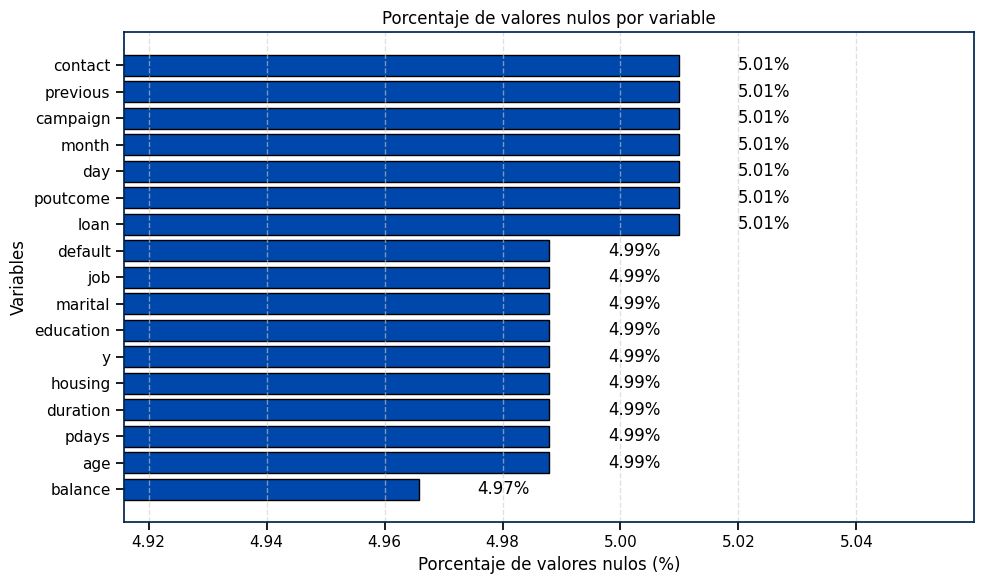

Cantidad de registros duplicados: 10


,count,mean,std,min,25%,50%,75%,max,rango
balance,4306.0,8829.596609,72317.091425,-3313.0,70.0,453.5,1538.25,711880.0,715193.0
day,4304.0,15.922630,8.240703,1.0,9.0,16.0,21.00,31.0,30.0
duration,4305.0,264.458304,261.527707,4.0,104.0,185.0,330.00,3025.0,3021.0
campaign,4304.0,2.780901,3.072688,1.0,1.0,2.0,3.00,50.0,49.0
pdays,4305.0,39.794657,100.257056,-1.0,-1.0,-1.0,-1.00,871.0,872.0
previous,4304.0,0.533457,1.673374,0.0,0.0,0.0,0.00,25.0,25.0


Sesgo (skewness) de las variables numéricas:


balance     9.607852
previous    5.939112
campaign    4.829506
duration    2.796322
pdays       2.727618
day         0.093361
dtype: float64

Cantidad de outliers por variable:


balance     486
day           0
duration    310
campaign    299
pdays       777
previous    773
dtype: int64

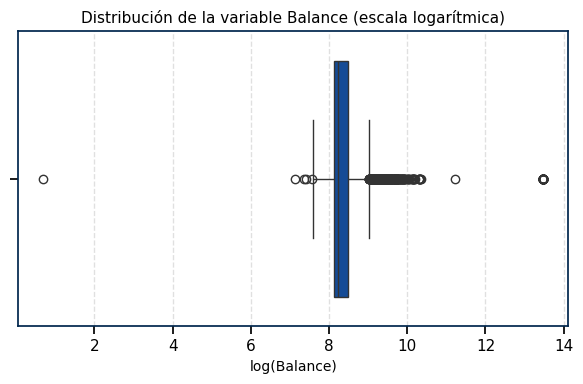

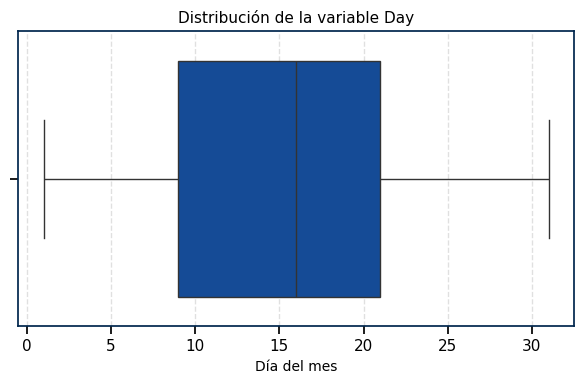

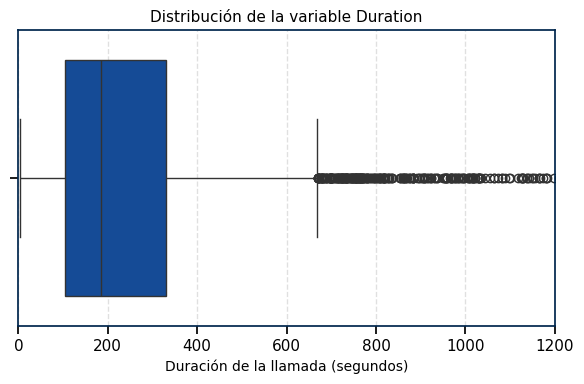

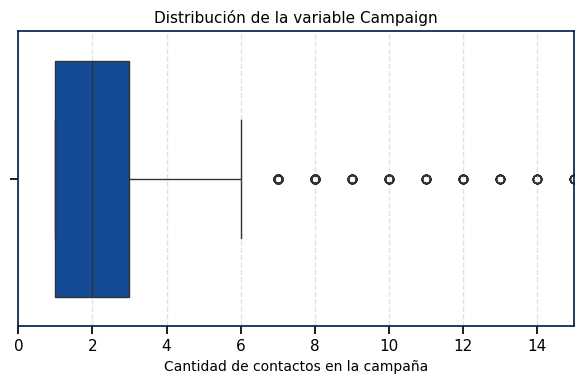

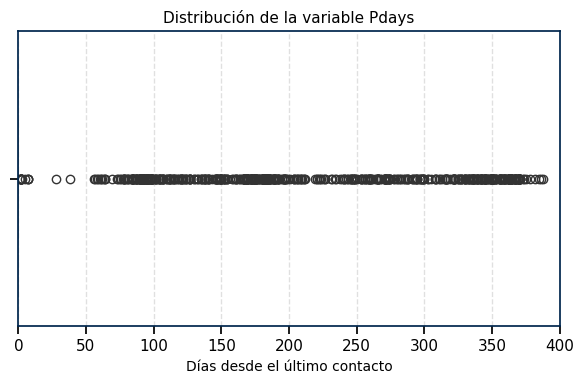

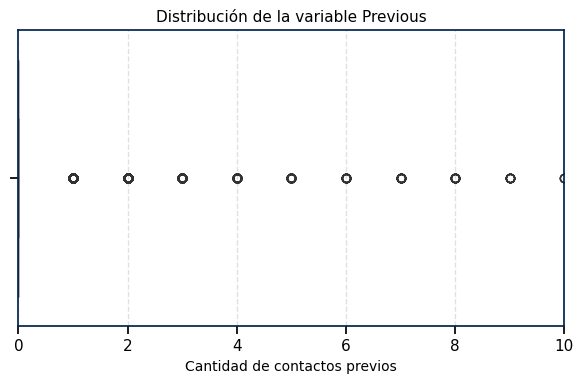

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:00<00:00, 431.27it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

-------------------- DISTRIBUCIÓN DE VARIABLES NUMÉRICAS CONTÍNUAS --------------------


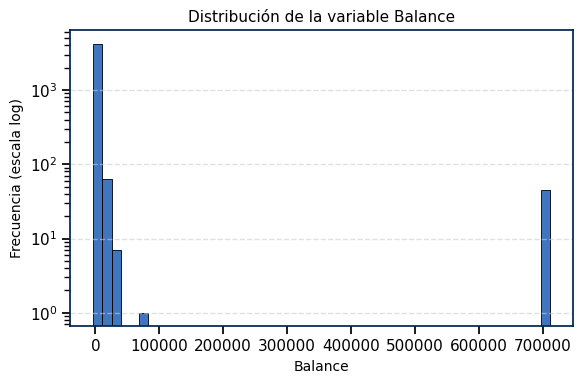

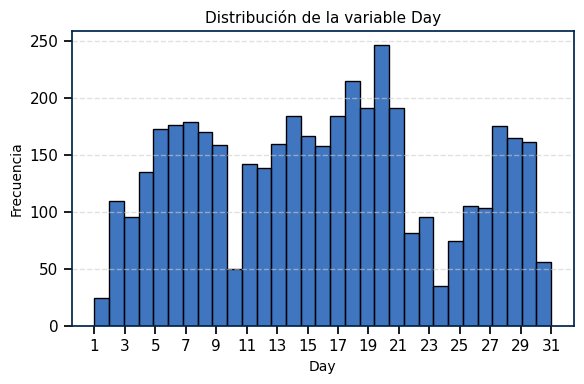

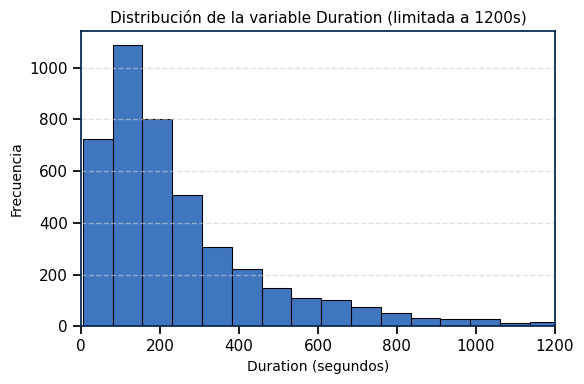

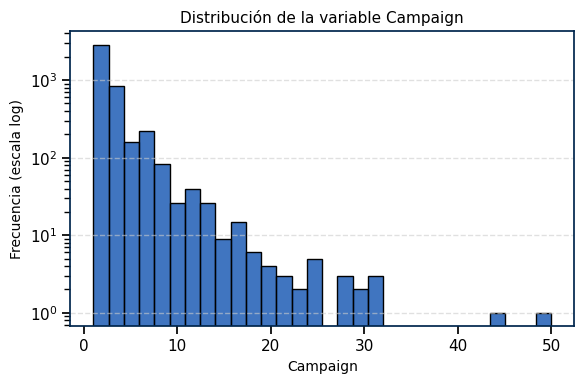

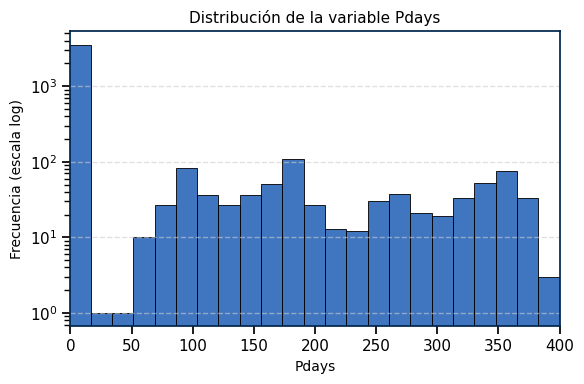

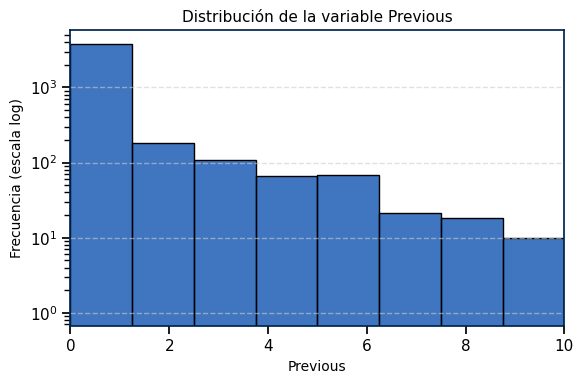

-------------------- DISTRIBUCIÓN DE VARIABLES BINARIAS --------------------


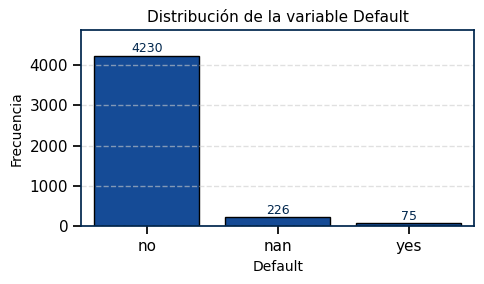

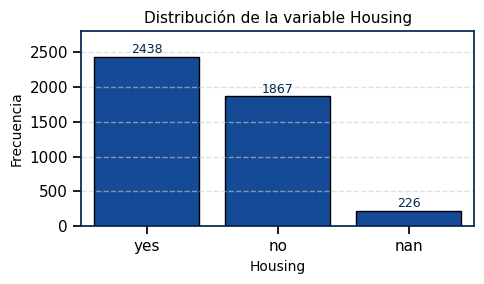

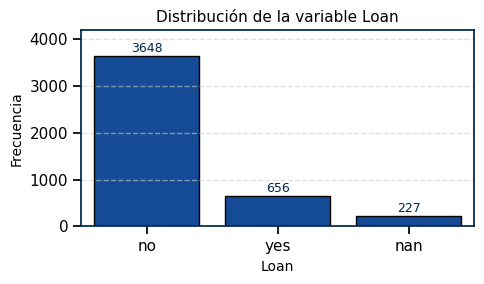

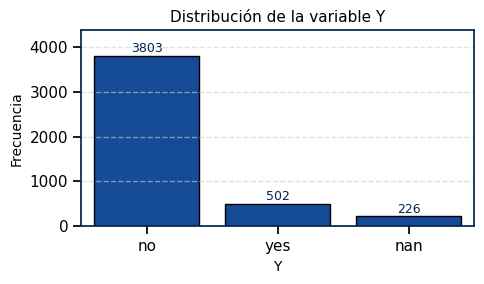

-------------------- DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS --------------------


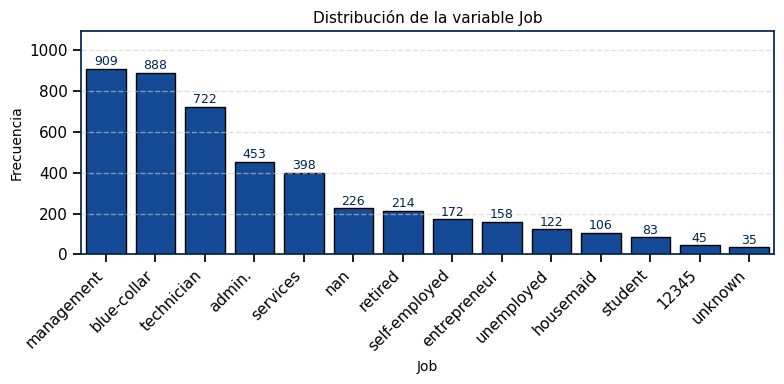

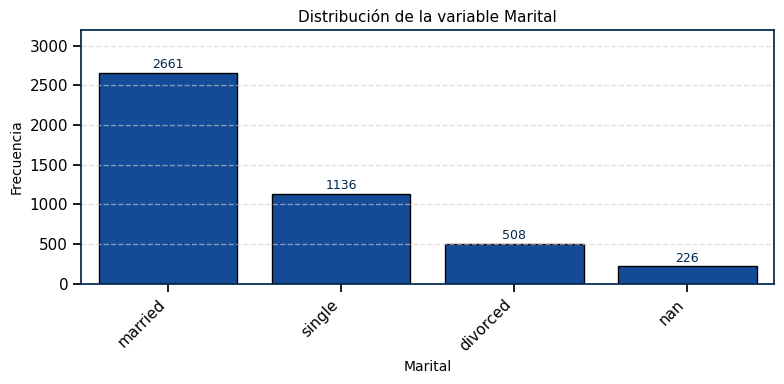

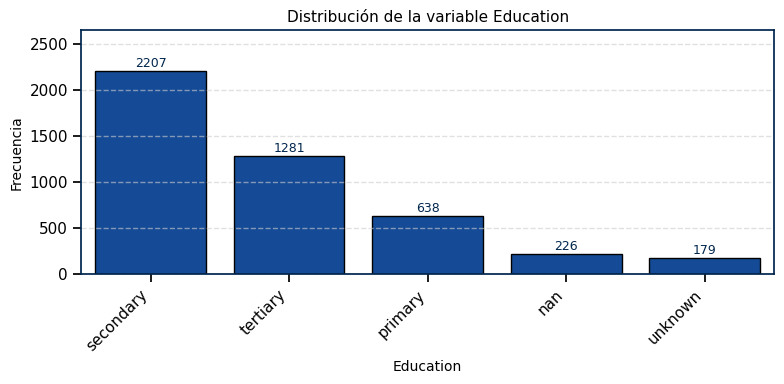

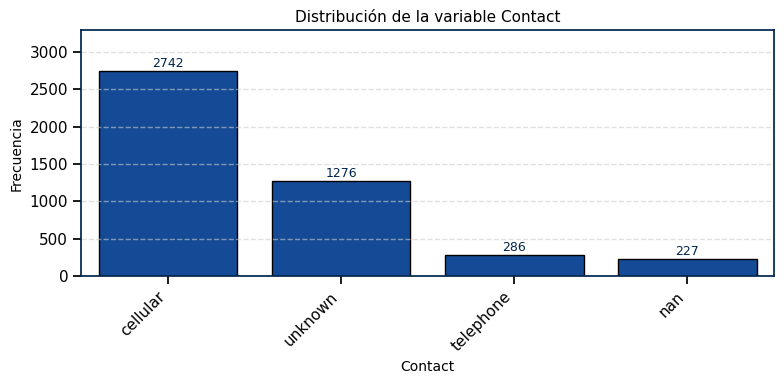

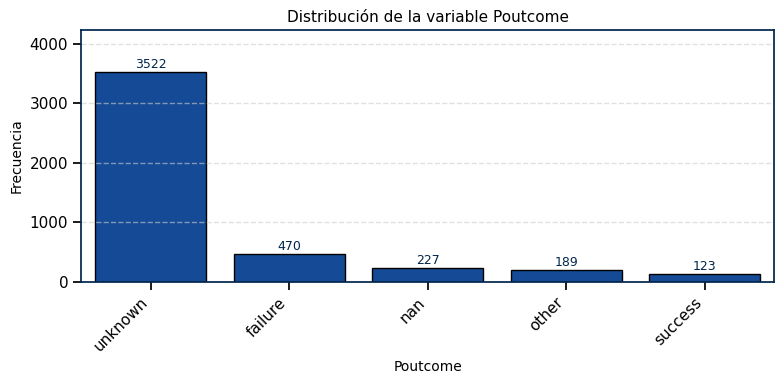

In [2]:
%matplotlib inline

print(f"El dataset contiene {df.shape[0]} filas (registros) y {df.shape[1]} columnas")

filas = df.shape[0]
columnas = df.shape[1]
total_celdas = df.size

info_df = pd.DataFrame({
    'Columnas': df.columns,
    'Tipo de dato': df.dtypes,
    'Valores no nulos': df.notnull().sum(),
    'Valores nulos': df.isnull().sum(),
    'Porcentaje nulos (%)': (df.isnull().sum() / len(df) * 100).round(2)
})

display(info_df)

print("------------------------- VALORES NULOS DEL DATASET ------------------------")
porcentaje_nulos = (df.isna().mean() * 100).sort_values()

plt.figure(figsize=(10,6))
plt.barh(porcentaje_nulos.index, porcentaje_nulos.values, color=color_base, edgecolor='black')
plt.xlabel('Porcentaje de valores nulos (%)')
plt.ylabel('Variables')
plt.title('Porcentaje de valores nulos por variable')

for i, v in enumerate(porcentaje_nulos.values):
    plt.text(v + 0.01, i, f"{v:.2f}%", va='center')

minv, maxv = porcentaje_nulos.min(), porcentaje_nulos.max()
plt.xlim(minv - 0.05, maxv + 0.05)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Chequeo de duplicados
duplicados = df.duplicated().sum()
print(f"Cantidad de registros duplicados: {duplicados}")

# Estadísticos descriptivos y rango
variables_numericas = ['balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
stats = df[variables_numericas].describe().T
stats["rango"] = stats["max"] - stats["min"]
display(stats)

# Sesgo (skewness)
sesgo = df[variables_numericas].skew().sort_values(ascending=False)
print("Sesgo (skewness) de las variables numéricas:")
display(sesgo)

# Outliers Qi
Q1 = df[variables_numericas].quantile(0.25)
Q3 = df[variables_numericas].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[variables_numericas] < (Q1 - 1.5 * IQR)) | (df[variables_numericas] > (Q3 + 1.5 * IQR))).sum()
print("Cantidad de outliers por variable:")
display(outliers)

# Boxplots para variables numéricas

# --- Balance ---
plt.figure(figsize=(6,4))

sns.boxplot(x=np.log1p(df['balance'] - df['balance'].min() + 1), color=color_base)

plt.title('Distribución de la variable Balance (escala logarítmica)', fontsize=11)
plt.xlabel('log(Balance)', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# --- Day ---
plt.figure(figsize=(6,4))
sns.boxplot(x=df['day'], color=color_base)
plt.title('Distribución de la variable Day', fontsize=11)
plt.xlabel('Día del mes', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Duration ---
plt.figure(figsize=(6,4))
sns.boxplot(x=df['duration'], color=color_base)
plt.title('Distribución de la variable Duration', fontsize=11)
plt.xlabel('Duración de la llamada (segundos)', fontsize=10)
plt.xlim(0, 1200)  # te muestra la mayoría de llamadas
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Campaign ---
plt.figure(figsize=(6,4))
sns.boxplot(x=df['campaign'], color=color_base)
plt.title('Distribución de la variable Campaign', fontsize=11)
plt.xlabel('Cantidad de contactos en la campaña', fontsize=10)
plt.xlim(0, 15)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Pdays ---
plt.figure(figsize=(6,4))
sns.boxplot(x=df['pdays'], color=color_base)
plt.title('Distribución de la variable Pdays', fontsize=11)
plt.xlabel('Días desde el último contacto', fontsize=10)
plt.xlim(0, 400)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Previous ---
plt.figure(figsize=(6,4))
sns.boxplot(x=df['previous'], color=color_base)
plt.title('Distribución de la variable Previous', fontsize=11)
plt.xlabel('Cantidad de contactos previos', fontsize=10)
plt.xlim(0, 10)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


profile = ProfileReport(df, title="Tema_4", explorative=True)
profile.to_file("Tema_4.html")

archivo_html = os.path.abspath("Tema_4.html")
webbrowser.open(f"file://{archivo_html}")

variables_binarias = ['default', 'housing', 'loan', 'y']
variables_categoricas = ['job', 'marital', 'education', 'contact', 'poutcome']

print("-------------------- DISTRIBUCIÓN DE VARIABLES NUMÉRICAS CONTÍNUAS --------------------")

# --- BALANCE ---
plt.figure(figsize=(6,4))
sns.histplot(df['balance'], bins=50, color=color_base, edgecolor='black', kde=False)
plt.yscale('log')
plt.title('Distribución de la variable Balance', fontsize=11)
plt.xlabel('Balance', fontsize=10)
plt.ylabel('Frecuencia (escala log)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- DAY ---
plt.figure(figsize=(6,4))
sns.histplot(df['day'], bins=31, color=color_base, edgecolor='black', kde=False)
plt.xticks(range(1,32,2))
plt.title('Distribución de la variable Day', fontsize=11)
plt.xlabel('Day', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- DURATION ---
plt.figure(figsize=(6,4))
sns.histplot(df['duration'], bins=40, color=color_base, edgecolor='black', kde=False)
plt.xlim(0, 1200)
plt.title('Distribución de la variable Duration (limitada a 1200s)', fontsize=11)
plt.xlabel('Duration (segundos)', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- CAMPAIGN ---
plt.figure(figsize=(6,4))
sns.histplot(df['campaign'], bins=30, color=color_base, edgecolor='black', kde=False)
plt.yscale('log')
plt.title('Distribución de la variable Campaign', fontsize=11)
plt.xlabel('Campaign', fontsize=10)
plt.ylabel('Frecuencia (escala log)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- PDAYS ---
plt.figure(figsize=(6,4))
sns.histplot(df['pdays'], bins=50, color=color_base, edgecolor='black', kde=False)
plt.xlim(0, 400)
plt.yscale('log')
plt.title('Distribución de la variable Pdays', fontsize=11)
plt.xlabel('Pdays', fontsize=10)
plt.ylabel('Frecuencia (escala log)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- PREVIOUS ---
plt.figure(figsize=(6,4))
sns.histplot(df['previous'], bins=20, color=color_base, edgecolor='black', kde=False)
plt.xlim(0, 10)
plt.yscale('log')
plt.title('Distribución de la variable Previous', fontsize=11)
plt.xlabel('Previous', fontsize=10)
plt.ylabel('Frecuencia (escala log)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("-------------------- DISTRIBUCIÓN DE VARIABLES BINARIAS --------------------")
for col in variables_binarias:
    plt.figure(figsize=(5,3))
    valores = df[col].value_counts(dropna=False)

    sns.barplot(
        x=valores.index.astype(str),
        y=valores.values,
        color=color_base,
        edgecolor='black'
    )
    
    plt.ylim(0, valores.max() * 1.15)
    plt.title(f'Distribución de la variable {col.capitalize()}', fontsize=11)
    plt.xlabel(col.capitalize(), fontsize=10)
    plt.ylabel('Frecuencia', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for i, v in enumerate(valores.values):
        plt.text(i, v + (valores.max() * 0.02), str(v), ha='center', fontsize=9, color=colores['oscuro'])
    
    plt.tight_layout()
    plt.show()

print("-------------------- DISTRIBUCIÓN DE VARIABLES CATEGÓRICAS --------------------")
for col in variables_categoricas:
    plt.figure(figsize=(8,4))
    valores = df[col].value_counts(dropna=False).sort_values(ascending=False)
    
    sns.barplot(
        x=valores.index.astype(str),
        y=valores.values,
        color=color_base,
        edgecolor='black'
    )

    plt.ylim(0, valores.max() * 1.20)
    plt.title(f'Distribución de la variable {col.capitalize()}', fontsize=11)
    plt.xlabel(col.capitalize(), fontsize=10)
    plt.ylabel('Frecuencia', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for i, v in enumerate(valores.values):
        plt.text(i, v + (valores.max() * 0.02), str(v), ha='center', fontsize=9, color=colores['oscuro'])
    
    plt.tight_layout()
    plt.show()

# Limpieza de datos e imputaciones

### Duplicados

In [3]:
df_cleaned = df.copy()

dup = df_cleaned.duplicated().sum()
print(f"Duplicados encontrados: {dup}")

if dup > 0:
    df_cleaned = df_cleaned.drop_duplicates()
    print(f"Duplicados eliminados. Nuevo total: {df_cleaned.shape[0]} filas.")
else:
    print("No se encontraron duplicados.")
    


Duplicados encontrados: 10
Duplicados eliminados. Nuevo total: 4521 filas.


### Corrección tipo de datos

In [4]:
missing_tokens = ['unknown', 'unknown_age', 'other', 'nonexistent', 'NA', 'na', 'None']
df_cleaned.replace(missing_tokens, np.nan, inplace=True)

# Asegurar tipos numéricos
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
for col in num_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

print("Tipos de datos corregidos y valores especiales convertidos a NaN.")

Tipos de datos corregidos y valores especiales convertidos a NaN.


### Inconsistencias y relaciones lógicas

In [5]:
# Rangos válidos
df_cleaned.loc[(df_cleaned['age'] < 18) | (df_cleaned['age'] > 100), 'age'] = np.nan
df_cleaned.loc[(df_cleaned['day'] < 1) | (df_cleaned['day'] > 31), 'day'] = np.nan

# Valores especiales en pdays
df_cleaned['pdays'] = df_cleaned['pdays'].replace(-1, np.nan)

# Relación previous - pdays - poutcome
df_cleaned.loc[df_cleaned['previous'] == 0, 'pdays'] = np.nan
df_cleaned.loc[df_cleaned['previous'] == 0, 'poutcome'] = 'nonexistent'


# Campañas y contactos negativos - NaN
for col in ['campaign', 'previous']:
    df_cleaned.loc[df_cleaned[col] < 0, col] = np.nan

print("Inconsistencias y relaciones lógicas corregidas.")

Inconsistencias y relaciones lógicas corregidas.


### Limpieza por variable 

In [6]:
# --- AGE ---
df_cleaned = df_cleaned[(df_cleaned['age'].between(18, 100)) | (df_cleaned['age'].isna())]
mediana_edad = df_cleaned['age'].median()
df_cleaned['age'] = df_cleaned['age'].fillna(mediana_edad)

# --- JOB ---
df_cleaned['job'] = (
    df_cleaned['job'].astype(str).str.strip().str.lower()
    .replace({'admin.': 'admin', '12345': np.nan, 'nan': np.nan, 'none': np.nan})
)

# --- MARITAL ---
df_cleaned['marital'] = (
    df_cleaned['marital'].astype(str).str.strip().str.lower()
    .replace({'nan': np.nan, 'none': np.nan})
)

# --- EDUCATION ---
df_cleaned['education'] = (
    df_cleaned['education'].astype(str).str.strip().str.lower()
    .replace({
        'basic.4y': 'primary', 'basic.6y': 'primary',
        'basic.9y': 'secondary', 'university.degree': 'tertiary',
        'high.school': 'secondary', 'illiterate': 'primary',
        'nan': np.nan, 'none': np.nan
    })
)

edu_dist = df_cleaned['education'].value_counts(normalize=True, dropna=True)
def imputar_proporcional(series):
    n_missing = series.isna().sum()
    if n_missing > 0 and len(edu_dist) > 0:
        sampled = np.random.choice(edu_dist.index, size=n_missing, p=edu_dist.values)
        series.loc[series.isna()] = sampled
    return series
df_cleaned['education'] = imputar_proporcional(df_cleaned['education'])


# --- DEFAULT / HOUSING / LOAN ---
for col in ['default', 'housing', 'loan']:
    df_cleaned[col] = (
        df_cleaned[col].astype(str).str.strip().str.lower()
        .replace({'yes': 1, 'no': 0})
        .astype(float)
    )

# --- DAY ---
df_cleaned = df_cleaned[(df_cleaned['day'] >= 1) & (df_cleaned['day'] <= 31)]
df_cleaned['day'] = df_cleaned['day'].astype('Int64')

# --- CAMPAIGN ---
q99 = df_cleaned['campaign'].quantile(0.99)
df_cleaned.loc[df_cleaned['campaign'] > q99, 'campaign'] = np.nan
df_cleaned['campaign'] = df_cleaned['campaign'].fillna(df_cleaned['campaign'].median()).astype('Int64')

# --- PREVIOUS ---
q99 = df_cleaned['previous'].quantile(0.99)
df_cleaned.loc[df_cleaned['previous'] > q99, 'previous'] = np.nan
df_cleaned['previous'] = df_cleaned['previous'].astype('Int64')

# --- PDAYS ---
df_cleaned.loc[df_cleaned['pdays'] == -1, 'pdays'] = np.nan
df_cleaned['pdays'] = df_cleaned['pdays'].astype('Int64')

# pdays = 400 significa "cliente nunca contactado"

df_cleaned['pdays'] = pd.to_numeric(df_cleaned['pdays'], errors='coerce')

df_cleaned['pdays_recod'] = df_cleaned['pdays'].apply(
    lambda x: 0 if pd.isna(x) or x == 400 else 400 - x
)

df_cleaned.drop(columns=['pdays'], inplace=True)

print("pdays recodificada correctamente como variable derivada pdays_recod.")

# --- POUTCOME ---
if 'poutcome' in df_cleaned.columns:
    df_cleaned.drop(columns=['poutcome'], inplace=True)
    print("poutcome eliminada por alta proporción de 'nonexistent/unknown'.")

# --- Y (variable objetivo) ---
df_cleaned['y'] = (
    df_cleaned['y'].astype(str).str.strip().str.lower()
    .replace({'yes': 1, 'no': 0, 'nan': np.nan, 'none': np.nan})
    .astype(float)
)
df_cleaned = df_cleaned[~df_cleaned['y'].isna()].reset_index(drop=True)

pdays recodificada correctamente como variable derivada pdays_recod.
poutcome eliminada por alta proporción de 'nonexistent/unknown'.


/var/folders/w5/r4237v9175jgsj0grkn8tkhr0000gn/T/ipykernel_34389/1956619046.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series.isna()] = sampled
/var/folders/w5/r4237v9175jgsj0grkn8tkhr0000gn/T/ipykernel_34389/1956619046.py:85: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'yes': 1, 'no': 0, 'nan': np.nan, 'none': np.nan})


### Columnas constantes / redundantes

In [7]:
# Eliminar columnas con un solo valor
constantes = [col for col in df_cleaned.columns if df_cleaned[col].nunique(dropna=False) <= 1]
if constantes:
    df_cleaned.drop(columns=constantes, inplace=True)
    print(f"Columnas constantes eliminadas: {constantes}")

# # Eliminar redundantes
# if 'duration' in df_cleaned.columns:
#     df_cleaned.drop(columns=['duration'], inplace=True)
#     print("duration eliminada (solo conocida post-contacto).")

# if 'pdays' in df_cleaned.columns:
#     df_cleaned.drop(columns=['pdays'], inplace=True)
#     print("pdays eliminada (alta correlación con previous).")

print(f"Columnas restantes: {df_cleaned.shape[1]}")

Columnas restantes: 16


### Imputación de nulos

In [8]:
# Numéricas con sesgos - mediana
cols_mediana = ['balance', 'campaign', 'previous']
imputer_med = SimpleImputer(strategy='median')
df_cleaned[cols_mediana] = imputer_med.fit_transform(df_cleaned[cols_mediana])

# Numéricas simétricas - media
cols_media = ['age', 'day']
imputer_mean = SimpleImputer(strategy='mean')
df_cleaned[cols_media] = imputer_mean.fit_transform(df_cleaned[cols_media])

# Categóricas - moda
cols_moda = ['job', 'marital', 'education', 'contact', 'month']
imputer_mode = SimpleImputer(strategy='most_frequent')
df_cleaned[cols_moda] = imputer_mode.fit_transform(df_cleaned[cols_moda])

# Binarias - completar con valor más frecuente
cols_bin = ['default', 'housing', 'loan']
for col in cols_bin:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

print("\nImputación final completada. Resumen de nulos:")
print(df_cleaned.isna().sum())


Imputación final completada. Resumen de nulos:
age              0
job              0
marital          0
education        0
default          0
balance          0
housing          0
loan             0
contact          0
day              0
month            0
duration       204
campaign         0
previous         0
y                0
pdays_recod      0
dtype: int64


### Verificación

In [9]:
print(f"Dataset final: {df_cleaned.shape[0]} filas y {df_cleaned.shape[1]} columnas")
print("Columnas finales:")
print(df_cleaned.columns.tolist())

print("\nCantidad total de valores nulos:", df_cleaned.isna().sum().sum())

df_cleaned.info()
df_cleaned.to_csv("df_cleaned.csv", index=False, encoding="utf-8")


Dataset final: 4077 filas y 16 columnas
Columnas finales:
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'previous', 'y', 'pdays_recod']

Cantidad total de valores nulos: 204
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4077 entries, 0 to 4076
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          4077 non-null   float64
 1   job          4077 non-null   object 
 2   marital      4077 non-null   object 
 3   education    4077 non-null   object 
 4   default      4077 non-null   float64
 5   balance      4077 non-null   float64
 6   housing      4077 non-null   float64
 7   loan         4077 non-null   float64
 8   contact      4077 non-null   object 
 9   day          4077 non-null   float64
 10  month        4077 non-null   object 
 11  duration     3873 non-null   float64
 12  campaign     4077 non-null   float64
 13 

# Análisis de datos mediante visualización

Paleta de colores utilizada

In [10]:
# Configuración de colores 

# Paleta principal 
colores = {
    'azul_principal': '#005B96',     
    'azul_oscuro': '#00264D',        
    'celeste': '#66A5D9',            
    'dorado': '#C8A200',             
    'verde_exito': '#7AA874',        
    'gris_claro': '#E8E8E8',         
    'gris_texto': '#4D4D4D'          
}

# Estilo general
plt.style.use('default')
sns.set_palette([colores['azul_principal']])
sns.set_context("notebook", font_scale=1.1)

plt.rcParams.update({
    'axes.facecolor': 'white',
    'axes.edgecolor': colores['azul_oscuro'],
    'axes.labelcolor': colores['azul_oscuro'],
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.color': colores['azul_oscuro'],
    'ytick.color': colores['azul_oscuro'],
    'grid.color': colores['gris_claro'],
    'grid.linestyle': '--',
    'grid.alpha': 0.5,
    'figure.facecolor': 'white',
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans']
})

# Paletas auxiliares coherentes con la temática
color_base = colores['azul_principal']
color_secundario = colores['celeste']
color_terciario = colores['dorado']
color_exito = colores['verde_exito']
color_rechazo = colores['azul_oscuro']
color_gris = colores['gris_claro']

# Paleta para etiquetas o categorías (útil en gráficos con hue)
legend_colors = {
    "No": color_rechazo,
    "Sí": color_exito
}

# Orden de leyenda estándar
legend_order = ["No", "Sí"]


In [11]:
label_map = {0: "No", 1: "Sí"}
legend_order = ["No", "Sí"]
legend_colors = {"No": color_rechazo, "Sí": color_exito}

def map_y_labels(s):
    """Convierte la columna y (0/1, bool o str) a etiquetas 'No'/'Sí'."""
    if s.dtype == bool:
        return s.map({False: "No", True: "Sí"})
    try:
        return s.astype(int).map(label_map)
    except Exception:
        return s.map({"0": "No", "1": "Sí"}).fillna("No")


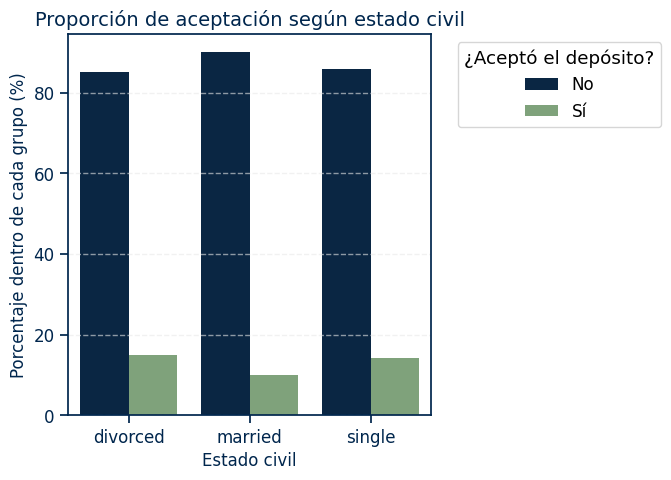

In [12]:
# Proporción de aceptación según estado civil

df_marital = df_cleaned[df_cleaned['marital'] != 'unknown'].copy()
tmp = df_marital.assign(y_label = map_y_labels(df_marital['y']))
marital_data = (
    tmp.groupby(['marital', 'y_label']).size()
       .reset_index(name='count')
)
marital_data['percentage'] = marital_data.groupby('marital')['count'].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(7,5))
sns.barplot(
    data=marital_data,
    x='marital', y='percentage', hue='y_label',
    hue_order=legend_order, palette=[legend_colors[h] for h in legend_order]
)
plt.title("Proporción de aceptación según estado civil", color=colores['azul_oscuro'])
plt.xlabel("Estado civil", color=colores['azul_oscuro'])
plt.ylabel("Porcentaje dentro de cada grupo (%)", color=colores['azul_oscuro'])
plt.grid(axis='y', linestyle='--', alpha=0.6, color=colores['gris_claro'])
plt.legend(title="¿Aceptó el depósito?", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


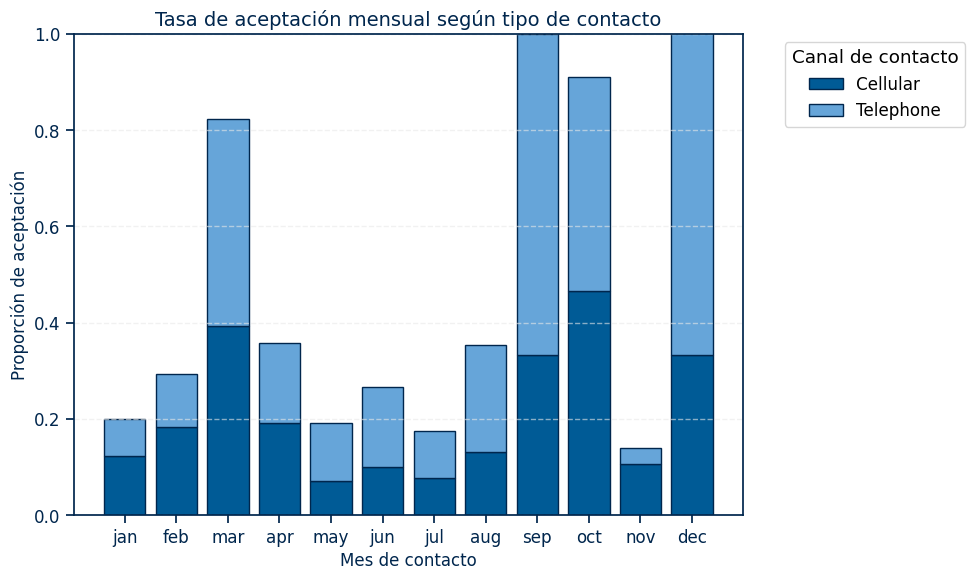

In [13]:
# Tasa de aceptación mensual según tipo de contacto

df_stack = (
    df_cleaned[df_cleaned['contact'].isin(['cellular', 'telephone'])]
      .groupby(['month', 'contact'])['y'].mean()
      .reset_index()
)

df_stack_pivot = (
    df_stack.pivot(index='month', columns='contact', values='y')
            .fillna(0.0)
)
order_months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
df_stack_pivot = df_stack_pivot.reindex(order_months)

plt.figure(figsize=(10,6))
bottom = np.zeros(len(df_stack_pivot))
contact_colors = {'cellular': color_base, 'telephone': color_secundario}

for col in df_stack_pivot.columns:
    vals = df_stack_pivot[col].values
    plt.bar(
        df_stack_pivot.index, vals,
        bottom=bottom, label=col.capitalize(),
        color=contact_colors.get(col, color_gris),
        edgecolor=color_rechazo
    )
    bottom = bottom + vals

plt.title("Tasa de aceptación mensual según tipo de contacto", color=color_rechazo)
plt.xlabel("Mes de contacto", color=color_rechazo)
plt.ylabel("Proporción de aceptación", color=color_rechazo)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6, color=color_gris)
plt.legend(title='Canal de contacto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

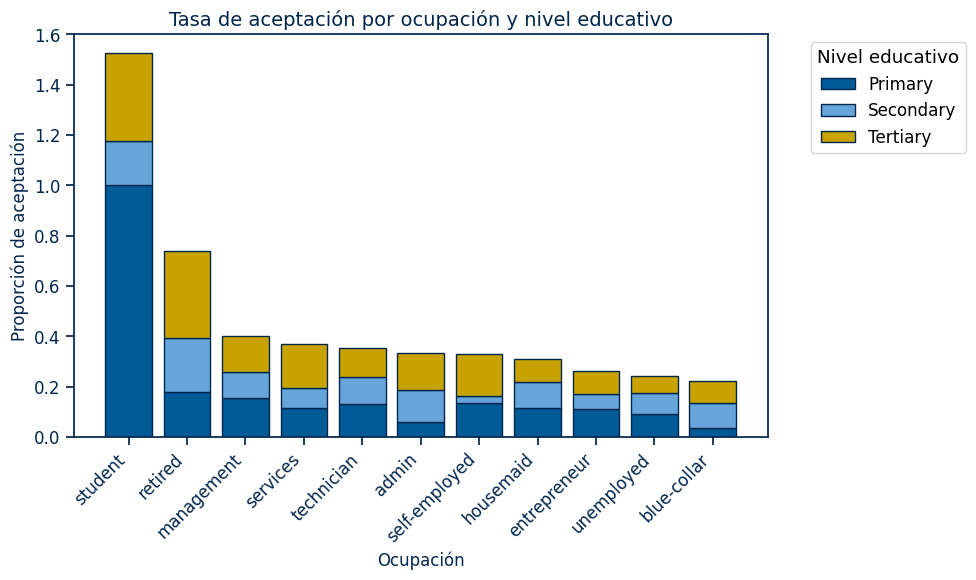

In [14]:
# Tasa de aceptación por ocupación y nivel educativo

df_job_edu = df_cleaned[df_cleaned['education'] != 'unknown'].copy()
df_grouped = df_job_edu.groupby(['job', 'education'])['y'].mean().reset_index()
df_pivot = df_grouped.pivot(index='job', columns='education', values='y').fillna(0.0)

# Orden de columnas educacionales si existen
edu_order = ['primary', 'secondary', 'tertiary', 'professional.course', 'illiterate']
edu_order = [c for c in edu_order if c in df_pivot.columns]
df_pivot = df_pivot[edu_order]

# Ordenar ocupaciones por total de aceptación (suma de proporciones)
df_pivot = df_pivot.assign(total=df_pivot.sum(axis=1)).sort_values('total', ascending=False).drop(columns='total')

plt.figure(figsize=(10,6))
bottom = np.zeros(len(df_pivot))
edu_palette = [color_base, color_secundario, color_terciario, '#999999', '#BBBBBB'][:len(df_pivot.columns)]

for col, color in zip(df_pivot.columns, edu_palette):
    vals = df_pivot[col].values
    plt.bar(df_pivot.index, vals, bottom=bottom, label=col.capitalize(),
            color=color, edgecolor=color_rechazo)
    bottom = bottom + vals

plt.title("Tasa de aceptación por ocupación y nivel educativo", color=color_rechazo)
plt.xlabel("Ocupación", color=color_rechazo)
plt.ylabel("Proporción de aceptación", color=color_rechazo)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nivel educativo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


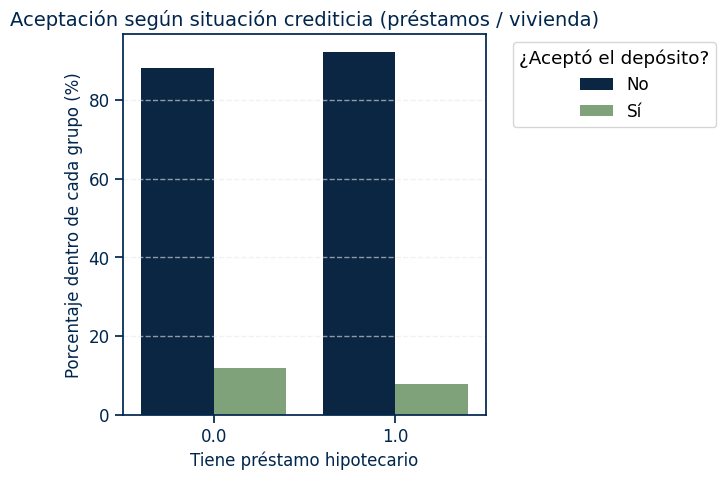

In [15]:
# Aceptación según situación crediticia
tmp = df_cleaned.assign(y_label = map_y_labels(df_cleaned['y']))
credit_data = (
    tmp.groupby(['housing', 'loan', 'y_label']).size()
       .reset_index(name='count')
)
credit_data['percentage'] = credit_data.groupby(['housing', 'loan'])['count'].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(7,5))
sns.barplot(
    data=credit_data,
    x='housing', y='percentage', hue='y_label',
    hue_order=legend_order, palette=[legend_colors[h] for h in legend_order],
    errorbar=None 
)
plt.title("Aceptación según situación crediticia (préstamos / vivienda)", color=colores['azul_oscuro'])
plt.xlabel("Tiene préstamo hipotecario", color=colores['azul_oscuro'])
plt.ylabel("Porcentaje dentro de cada grupo (%)", color=colores['azul_oscuro'])
plt.grid(axis='y', linestyle='--', alpha=0.6, color=colores['gris_claro'])
plt.legend(title="¿Aceptó el depósito?", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Modelo

### Preparación de datos

In [16]:
target_col = 'y'
if df_cleaned[target_col].dtype != 'bool':
    df_cleaned[target_col] = df_cleaned[target_col].replace({'yes': True, 'no': False, 1: True, 0: False}).astype(bool)

X = df_cleaned.drop(columns=[target_col])
y = df_cleaned[target_col].astype(int)

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(exclude=['number']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

/var/folders/w5/r4237v9175jgsj0grkn8tkhr0000gn/T/ipykernel_34389/876534292.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned[target_col] = df_cleaned[target_col].replace({'yes': True, 'no': False, 1: True, 0: False}).astype(bool)


### Procesamiento y modelo

In [17]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocess = ColumnTransformer([
    ('cat', ohe, cat_cols),
    ('num', 'passthrough', num_cols)
])

modelo = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    random_state=42
)

pipe = Pipeline([
    ('prep', preprocess),
    ('clf', modelo)
])

param_grid = {
    'clf__max_depth': [3, 4, 5, 6, 8, None],
    'clf__min_samples_leaf': [1, 5, 10, 20],
    'clf__min_samples_split': [2, 10, 20]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=cv, n_jobs=1, verbose=0)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

### Evaluación

In [18]:
def evaluar(modelo, X, y):
    y_pred = modelo.predict(X)
    y_prob = modelo.predict_proba(X)[:, 1]
    return {
        'Exactitud': accuracy_score(y, y_pred),
        'Precisión': precision_score(y, y_pred, zero_division=0),
        'Sensibilidad': recall_score(y, y_pred, zero_division=0),
        'F1': f1_score(y, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y, y_prob)
    }, confusion_matrix(y, y_pred), y_pred, y_prob

train_m, cm_train, _, _ = evaluar(best_model, X_train, y_train)
test_m, cm_test, y_test_pred, y_test_prob = evaluar(best_model, X_test, y_test)

metricas_df = pd.DataFrame([train_m, test_m], index=['Entrenamiento', 'Prueba'])
display(metricas_df)

,Exactitud,Precisión,Sensibilidad,F1,ROC-AUC
Entrenamiento,0.830113,0.377254,0.721485,0.495446,0.864276
Prueba,0.806373,0.327957,0.648936,0.435714,0.806956


### Matriz de confusión

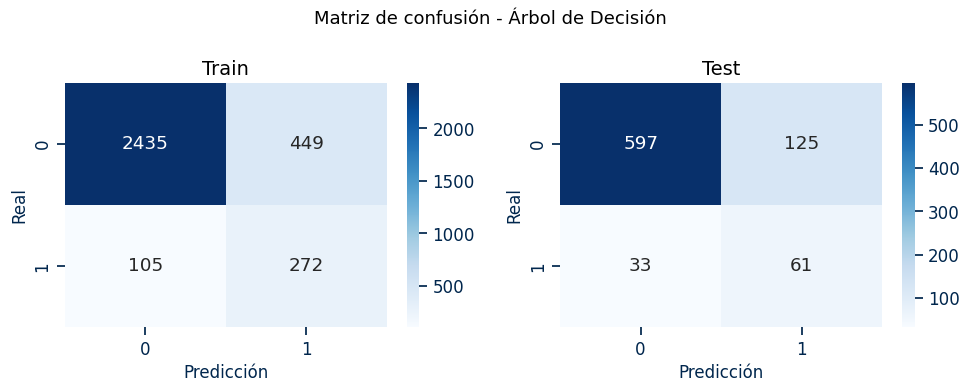

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[0].set_title("Train"), axes[1].set_title("Test")
for ax in axes: ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
plt.suptitle("Matriz de confusión - Árbol de Decisión", fontsize=13)
plt.tight_layout(); plt.show()

### Curvas ROC y Precisión - Recall

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


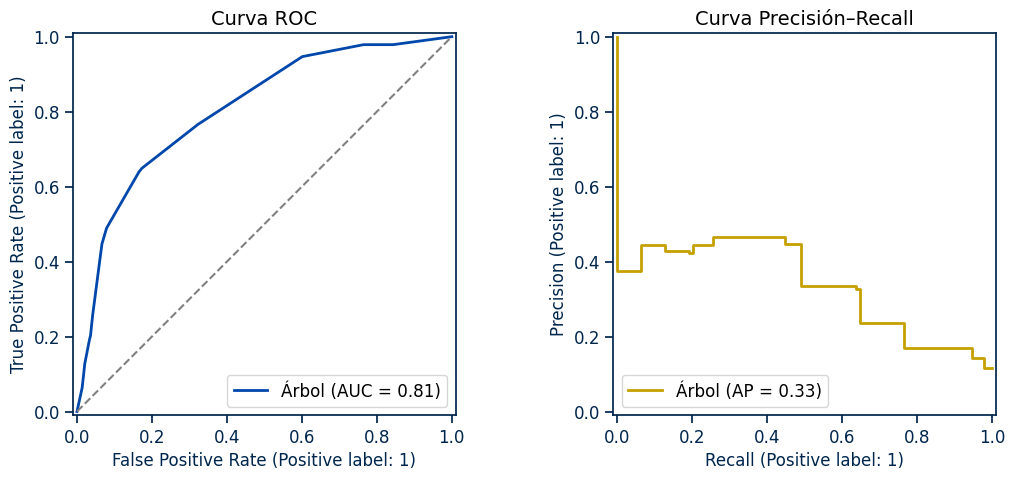

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
RocCurveDisplay.from_predictions(y_test, y_test_prob, name='Árbol', color='#0047AB', lw=2, ax=ax[0])
PrecisionRecallDisplay.from_predictions(y_test, y_test_prob, name='Árbol', color='#C5A100', lw=2, ax=ax[1])
ax[0].plot([0, 1], [0, 1], '--', color='gray')
ax[0].set_title("Curva ROC"); ax[1].set_title("Curva Precisión–Recall")
plt.tight_layout(); plt.show()

### Importancia de variables

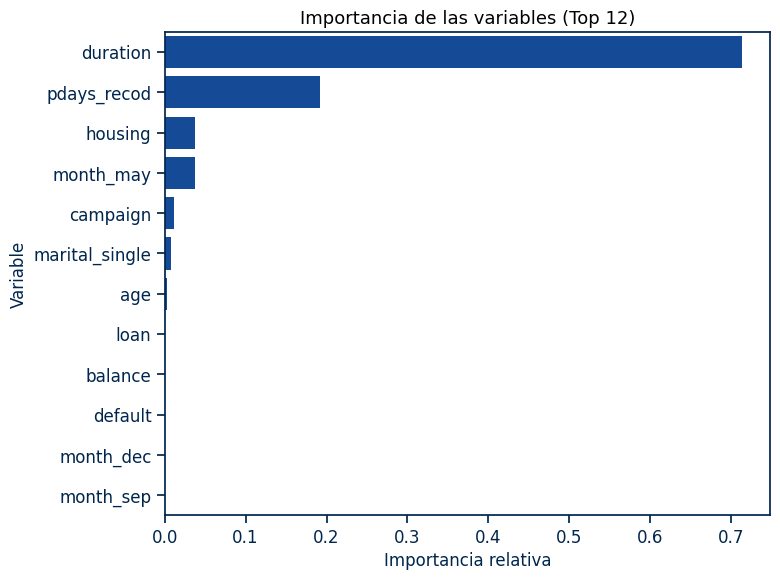

In [21]:
ohe_fitted = best_model.named_steps['prep'].named_transformers_['cat']
ohe_feature_names = ohe_fitted.get_feature_names_out(cat_cols)
feature_names = np.concatenate([ohe_feature_names, np.array(num_cols)])

importances = best_model.named_steps['clf'].feature_importances_
fi = pd.DataFrame({'Variable': feature_names, 'Importancia': importances}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=fi.head(12), x='Importancia', y='Variable', color='#0047AB')
plt.title("Importancia de las variables (Top 12)", fontsize=13)
plt.xlabel("Importancia relativa"); plt.ylabel("Variable")
plt.tight_layout(); plt.show()

### Árbol

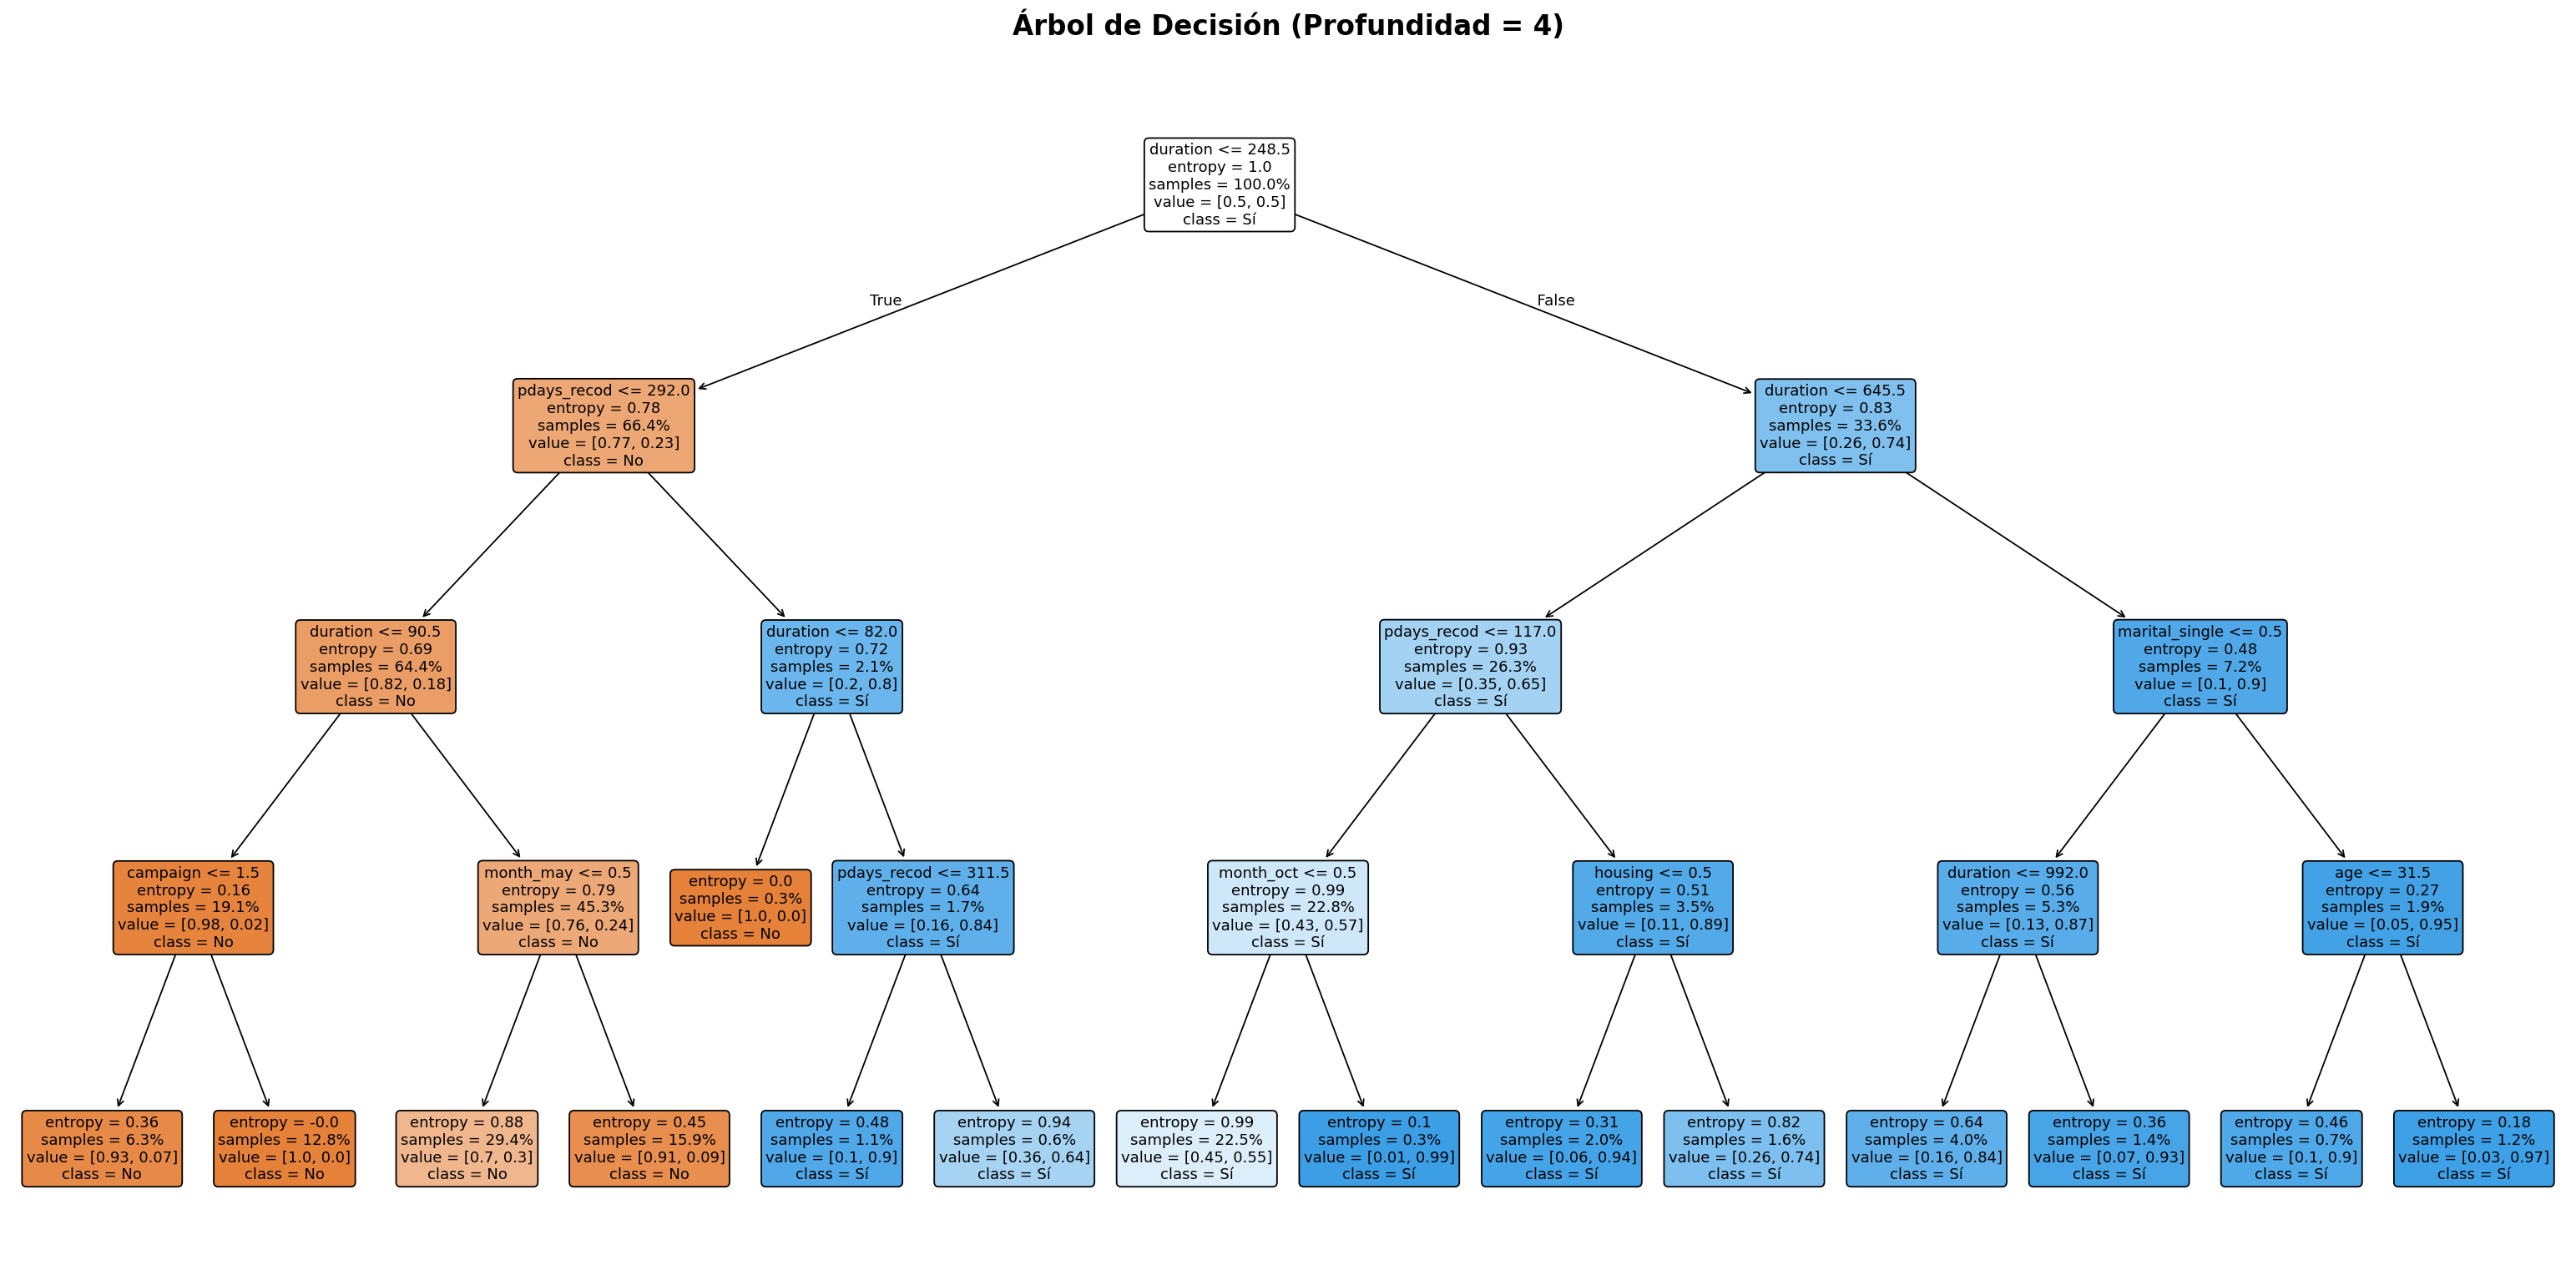

In [25]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_small = DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    max_depth=4,
    min_samples_leaf=10,
    random_state=42
)

small_pipe = Pipeline([
    ('prep', preprocess),
    ('clf', tree_small)
])

small_pipe.fit(X_train, y_train)

ohe_fitted = small_pipe.named_steps['prep'].named_transformers_['cat']
ohe_feature_names = ohe_fitted.get_feature_names_out(cat_cols)
feature_names = np.concatenate([ohe_feature_names, np.array(num_cols)])

plt.figure(figsize=(24, 12), dpi=130)

plot_tree(
    small_pipe.named_steps['clf'],
    feature_names=feature_names,
    class_names=['No', 'Sí'],
    filled=True,
    rounded=True,
    fontsize=10,
    proportion=True,
    node_ids=False,
    precision=2
)

plt.title("Árbol de Decisión (Profundidad = 4)", fontsize=18, weight="bold", pad=20)
plt.tight_layout()
plt.show()
